This notebook attempts to recreate the seminal [ResNet](https://arxiv.org/pdf/1512.03385.pdf) paper on TensorFlow. We'll create the same architecture as the ResNet 50:
<img src="images/resnet-50-summary.png">

We'll use the same hyperparameters, including:
- weight initialization
- momentum
- weight decay
- learning rate (and learning rate decay)
- optimization algorithm
- minibatch size

We will be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which the authors also trained on, and use the same data augmentation steps described in the research paper.

One notable difference from the original paper: due to economic and environmental (CO2 emission) concerns, and because this notebook is mostly for didactic purposes, we won't train for 64k iterations like the ResNet authors do; we'll only train 1/100 that amount (640 iterations).

Also note that this notebook will only deal with the 2015 paper, not later, improved versions of the model.

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.initializers import HeUniform
from tensorflow_addons.optimizers import SGDW

## Load Data:
We'll load data, create train/val/test splits, and also define the label names. CIFAR-10 is built into TensorFlow/Keras' datasets -- so we can easily load the data.

In [31]:
# Load data:

data = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = data

In [32]:
# Convert labels to one-hot encoding:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#### Validation-set/Dev-set:

The authors of the ResNet paper further split the 50k train set into 45k/5k train/val sets:
>  We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations, and terminate training at 64k iterations, which is determined on a 45k/5k train/val split. (p. 7)

N.b. we could have also specified the train/validation split as an argument in TensorFlow's `model.fit()`.

In [33]:
x_train, x_val = x_train[:45000], x_train[45000:]
y_train, y_val = y_train[:45000], y_train[45000:]

Our class labels can be found on the [CIFAR-10 dataset site](https://www.cs.toronto.edu/~kriz/cifar.html).

In [34]:
LABEL_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

NUM_CLASSES = len(LABEL_NAMES)

## Explore Data:
Let's take a look at our dataset and what individual images from the dataset looks like:

In [35]:
print('x_train shape:', x_train.shape)
print('x_teset shape:', x_test.shape)

m_train_examples = x_train.shape[0]
m_val_examples = x_val.shape[0]
m_test_examples = x_test.shape[0]

print('# of train examples:', m_train_examples)
print('# of val/dev-set examples:', m_val_examples)
print('# of test examples:', m_test_examples)

# Double check that the number of labels matches the number of data:
assert m_train_examples == y_train.shape[0]
assert m_val_examples == y_val.shape[0]
assert m_test_examples == y_test.shape[0]


image_shape = x_train.shape[1:]
IMG_SIZE = image_shape[0]  # We'll use this constant for later. N.b. the height and width of CIFAR-10 images are equal.
print('image shape:', image_shape)

x_train shape: (45000, 32, 32, 3)
x_teset shape: (10000, 32, 32, 3)
# of train examples: 45000
# of val/dev-set examples: 5000
# of test examples: 10000
image shape: (32, 32, 3)


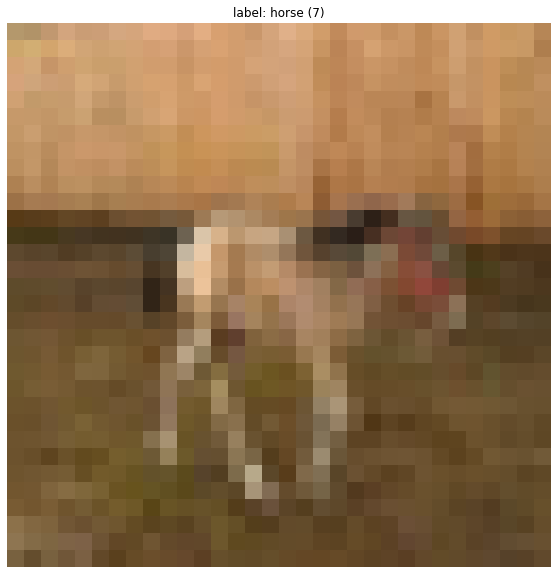

In [43]:
# Let's grab a random image before we process the dataset:
RAND_INDEX = np.random.randint(m_train_examples)
example_img = x_train[RAND_INDEX]

label = np.argmax(y_train[RAND_INDEX])  # We use `argmax` since we converted the labels from list of ints to one-hot encoding
img_title = f'label: {LABEL_NAMES[label]} ({label})'

# If we don't want to cast to int, then we would have to scale the data by 255 rather than by the STD (see above);
# this is a Matplotlib thing -- it expects floats to be between 0-1:
plt.imshow(example_img.astype('uint8'))
plt.title(img_title)
plt.axis('off')
plt.show()

## Pre-processing Layers:

As with most computer vision tasks, our model can greatly benefit with more data. We'll use data augmentation to suplement our dataset, and we'll follow the same steps for data augmentation as in the ResNet paper:
> We follow the simple data augmentation... 4 pixels are padded on each side, and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.

We'll create pre-processing layer that we'll add directly as part of our model. 
According to the [TensorFlow docs](https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2):
> Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).
Which means that this data agumentation layer will be utilized during training, but won't affect inference during testing/prediction or when deployed.

The other minor benefit is that it standardizes our inputs; so, we don't have to create a separate data transform for inference. This is also mentioned by the docs:
> When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers).

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.ZeroPadding2D(padding=(4, 4)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomCrop(IMG_SIZE, IMG_SIZE)
])

In [9]:
# Subtract mean:
# We can also use `adapt()` -- see <https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method>
mean = np.mean(x_train)

# TODO: Why doesn't the original ResNet paper scale by STD?
normalize_data = tf.keras.Sequential([
  layers.Normalization(mean=mean, variance=1)
])

## Model Architecture:

For CIFAR-10, the authors use [He initialization](https://arxiv.org/pdf/1502.01852.pdf), rather than Xavier (Glorot) for weight initialization:
> We use a weight decay of 0.0001 and momentum of 0.9, and adopt the weight initialization in \[13\] and BN \[16\] but with no dropout. These models are trained with a minibatch size of 128 on two GPUs. (p. 7)

In [10]:
def identity_block(input_tensor, num_filters:tuple or list, stage_label:int, block_label:int, print_dimensions:bool=True):
    """ Standard block in ResNet -- corresponds to when input activation (e.g. a[l]) has the same dimension as output activation
        a[l+2].
        
        Note: Identity blocks' shortcuts (skip connections) are parameter-free (since they're simply adding input tensors)
    """
    
    num_filters_1, num_filters_2, num_filters_3 = num_filters
    CONV_BASE_NAME = 'conv%s_%s' % (stage_label, block_label)
    BATCH_NORM_BASE_NAME = 'batch_norm%s_%s' % (stage_label, block_label)

    # n.b. we don't specify strides, the default value for in `Conv2D` is (1, 1) which is what we want in `identity_block`:
    # `kernel_size` is a required arg for `Conv2D`, but we use named args here for clarity:
    x = layers.Conv2D(num_filters_1, kernel_size=(1, 1), padding='valid', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'a')(input_tensor)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'a')(x) # axis should be set to features
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters_2, kernel_size=(3, 3), padding='same', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'b')(x)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters_3, kernel_size=(1, 1), padding='valid', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'c')(x)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'c')(x)
    
    if print_dimensions:
        print('------- %s - identity block -------' % stage_label)
        print('input_tensor shape:', input_tensor.shape)
        print('x shape:', x.shape, end='\n\n')
    
    x = tf.keras.layers.add([x, input_tensor])  # Inject skip connection
    x = layers.Activation('relu')(x)

    return x

def conv_block(input_tensor, num_filters:tuple or list, stage_label:int, block_label:int, strides:tuple=(2, 2), print_dimensions:bool=True):
    """ The conv block is used when input and output have different dimensions.
    
        The conv black differs from identity block by having convolution layer in the skip connection;
        The conv layer in the shortcut is used to resize the input to different dimension so that the dimensions 
        match when the shortcut is added (tf.keras.layers.add) back to the main path.
    """
    
    num_filters_1, num_filters_2, num_filters_3 = num_filters
    CONV_BASE_NAME = 'conv%s_%s' % (stage_label, block_label)
    BATCH_NORM_BASE_NAME = 'batch_norm%s_%s' % (stage_label, block_label)
    
    # If strides != 1, then we are downsampling/changing dimensions.
    # In standard practice, the image dimensions decrease in later layers, so this is ok.

    # `kernel_size` is a required arg for `Conv2D`, but we use named args here for clarity:
    x = layers.Conv2D(num_filters_1, kernel_size=(1, 1), strides=strides, padding='valid', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'a')(input_tensor)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'a')(x) # axis should be set to features
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters_2, kernel_size=(3, 3), padding='same', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'b')(x)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters_3, kernel_size=(1, 1), padding='valid', kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'c')(x)
    x = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'c')(x)
    x = layers.Activation('relu')(x)

    # Add shortcut to block:
    shortcut = layers.Conv2D(num_filters_3, kernel_size=(1, 1), strides=strides, padding='valid', 
                             kernel_initializer=HeUniform(), name=CONV_BASE_NAME+'shortcut')(input_tensor)
    shortcut = layers.BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'shortcut')(shortcut)

    if print_dimensions:
        print('------- %s - conv block -------' % stage_label)
        print('input_tensor shape:', input_tensor.shape)
        print('x shape:', x.shape)
        print('shortcut shape:', shortcut.shape, end='\n\n')
    
    x = tf.keras.layers.add([x, shortcut])  # Inject skip connection
    x = layers.Activation('relu')(x)
    
    return x

In [11]:
# Model:

i = layers.Input(shape=image_shape)
x = normalize_data(i)
x = data_augmentation(x)
x = layers.ZeroPadding2D((3, 3))(x)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=HeUniform(), name='conv1')(x)
x = layers.BatchNormalization(name='batch_norm1')(x)  # axis=-1 is already default
x = layers.Activation('relu')(x)
x = layers.MaxPool2D((3, 3), strides=(2, 2), name='max_pool1')(x)

# N.b. the # of filters passed to each res block is important -- if it's not correct,
# we will get dimension mismatch (specifically, when trying to add the skip connection)
x = conv_block(x,     [64, 64, 256], stage_label=2, block_label=1, strides=(1, 1))
x = identity_block(x, [64, 64, 256], stage_label=2, block_label=2)
x = identity_block(x, [64, 64, 256], stage_label=2, block_label=3)

x = conv_block(x,     [128, 128, 512], stage_label=3, block_label=1, strides=(2, 2))
x = identity_block(x, [128, 128, 512], stage_label=3, block_label=2)
x = identity_block(x, [128, 128, 512], stage_label=3, block_label=3)
x = identity_block(x, [128, 128, 512], stage_label=3, block_label=4)

x = conv_block(x,     [256, 256, 1024], stage_label=4, block_label=1, strides=(2, 2))
x = identity_block(x, [256, 256, 1024], stage_label=4, block_label=2)
x = identity_block(x, [256, 256, 1024], stage_label=4, block_label=3)
x = identity_block(x, [256, 256, 1024], stage_label=4, block_label=4)
x = identity_block(x, [256, 256, 1024], stage_label=4, block_label=5)
x = identity_block(x, [256, 256, 1024], stage_label=4, block_label=6)

x = conv_block(x,     [512, 512, 2048], stage_label=5, block_label=1, strides=(2, 2))
x = identity_block(x, [512, 512, 2048], stage_label=5, block_label=2)
x = identity_block(x, [512, 512, 2048], stage_label=5, block_label=3)

x = layers.GlobalAvgPool2D(name='avg_pool')(x)
x = layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=HeUniform(), name='softmax_prediction')(x)

model = Model(i, x)

In [14]:
model.summary()

## Train Model:

#### Hyperparameters:
Recall that the ResNet authors use a weight decay of 0.0001, momentum of 0.9, and a mini batch size of 128:
> We use a weight decay of 0.0001 and momentum of 0.9, and adopt the weight initialization in \[13\] and BN \[16\] but with no dropout. These models are trained with a minibatch size of 128 on two GPUs. (p. 7)

The authors also use SGD rather than Adam:
> We use SGD... (p. 4)

When training on CIFAR-10, the authors divide their learning rate by 10 at the 32k and 48k iteration marks:
> We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations, and terminate training at 64k iterations (p. 7)

Since we won't be training for 64k iterations in this notebook, our learning rate boundries will be 320 and 480. Therefore, our 320, 480, and 640 demarcations are 1/100th the size of the original paper, and if we want change the duration, it can/should be done with a constant multiplier.

In [44]:
# Create learning-rate schedule:

# Recall that we only run 1/100th the number of iterations that the ResNet paper does:
step = tf.Variable(0, trainable=False)

boundaries = [32e1, 48e1]
STOP_ITERATION_EPOCH = int(64e1)
schedule = PiecewiseConstantDecay(boundaries, [1e-0, 1e-1, 1e-2])

learning_rate_decay = 1e-1 * schedule(step)

In [16]:
model.compile(
    optimizer=SGDW(weight_decay=0.0001, learning_rate=learning_rate_decay, momentum= 0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
BATCH_SIZE = 128

In [18]:
model_history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=BATCH_SIZE,
    epochs=STOP_ITERATION_EPOCH,
    validation_data=(x_val, y_val)
)

## Model evaluation:

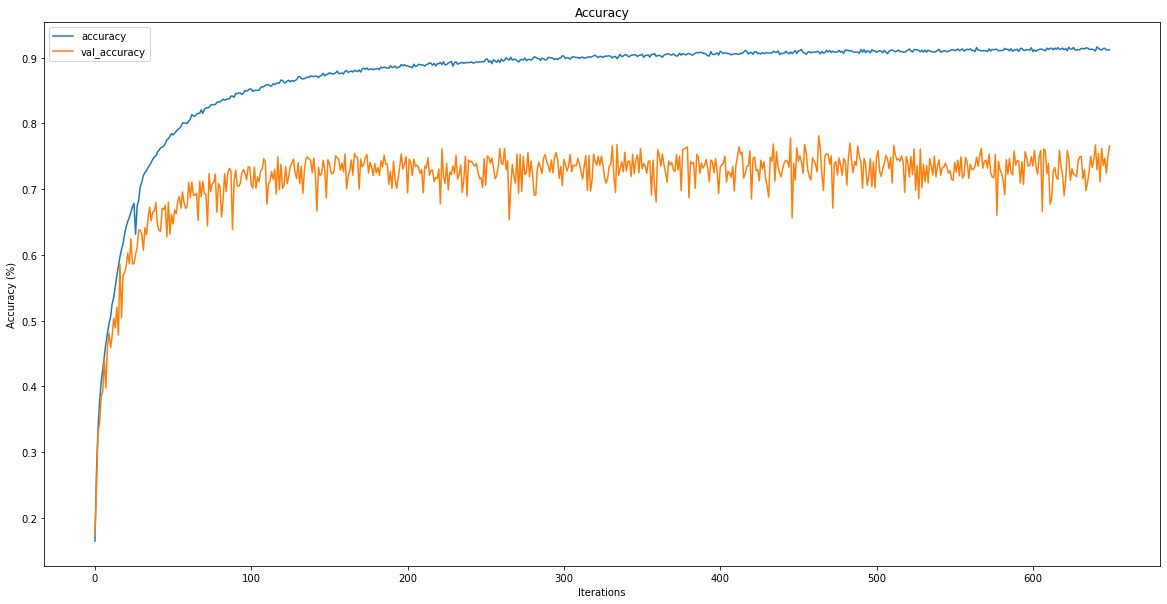

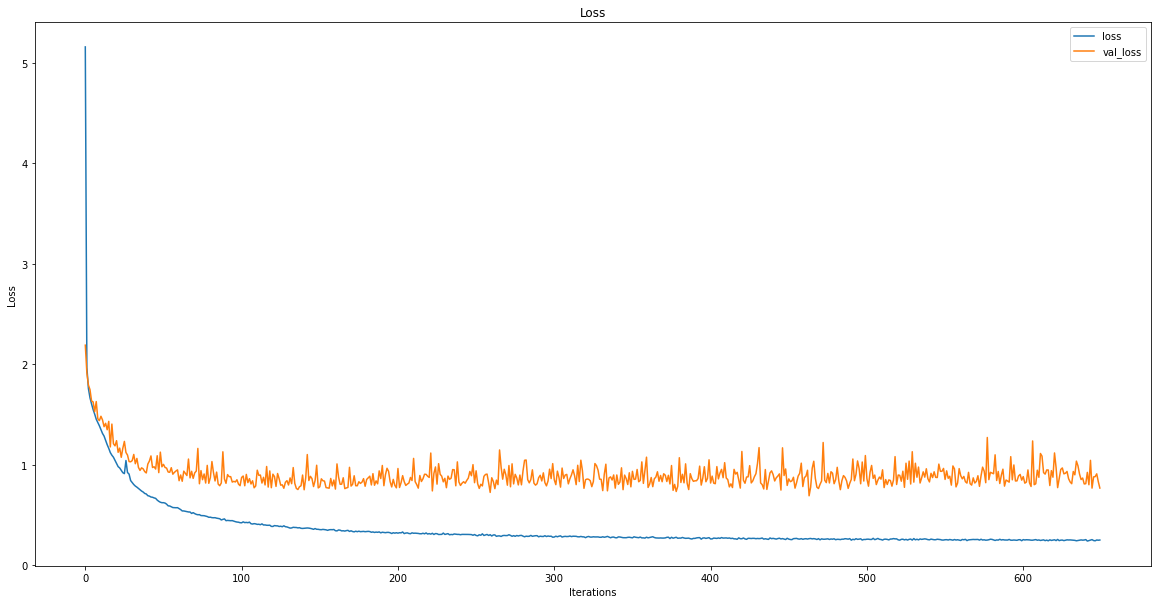

In [15]:
# Increase figure size:
plt.rcParams["figure.figsize"] = (20,10)

# Plot accuracy:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.show()

# Plot loss:
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [19]:
model.evaluate(
    x_test,
    y_test,
    batch_size=BATCH_SIZE
)

79/79 [==============================] - 34s 415ms/step - loss: 0.8041 - accuracy: 0.7551


[0.8041198253631592, 0.7551000118255615]

## Conclusion:

Our model has a train/validation/test accuracies of 93%/73%/75%, respectively.

While 75% accuracy isn't a great score, we trained for 650 iterations vs 65,000 iterations as the ResNet authors did. Moreover, we can use this TensorFlow implementation as a baseline, and try experimenting with different hyperparameters.